<br>
<h1 style="color:darkgreen; font-family:lato; font-size:300%; text-align:center;"> 
    Stock market
</h1>

***

## Imports and settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
import seaborn as sns; sns.set()
import pandas as pd
import pandas_datareader.data as web
import datetime
import scipy.optimize as optim
import math

fsize=(15,6)

We will be using Yahoo to get the information we need. It's worth saying that Yahoo gives a lot of information on stocks but we should make use of the Adjusted Closing Price because it's not only the closing price; it also takes into account other factors like dividends and stock splits. 

## Stocks and Dates

In [2]:
%%time
stocks = ['WMT', 'AAPL', 'GOOGL', 'F', 'AAL', 'DIS', 'MSFT', 'FB' , 'AMZN', 'NFLX']

years = 3
end_date = datetime.datetime.today().strftime('%m/%d/%Y')
start_date = (datetime.datetime.today() - datetime.timedelta(365*years)).strftime('%m/%d/%Y')

df = web.DataReader(stocks, data_source= 'yahoo', start=start_date, end = end_date)['Adj Close']

CPU times: user 479 ms, sys: 53.3 ms, total: 533 ms
Wall time: 6.66 s


Let's plot the value of these stocks over time

## EDA
An Exploratory Data Analysis is always necessary to have an idea of what we are dealing with. Let's ask pandas to describe our dataframe and then plot it as it is 

In [3]:
df.describe()

Symbols,WMT,AAPL,GOOGL,F,AAL,DIS,MSFT,FB,AMZN,NFLX
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,111.783837,72.416036,1352.697996,8.556016,26.142480,128.602550,153.329987,205.471034,2208.419215,389.805636
std,20.209055,31.022472,288.356904,1.700384,10.027611,24.563806,47.522764,44.434285,624.696008,85.184595
min,78.224243,34.669640,984.669983,4.010000,9.040000,85.760002,88.691101,124.059998,1343.959961,233.880005
25%,93.765659,47.559650,1144.117462,7.732500,15.822500,110.283804,108.203314,174.055004,1755.309998,326.725014
50%,113.194401,58.060003,1241.334961,8.741339,28.269586,124.959999,137.553001,193.014999,1890.640015,363.869995
75%,128.333603,95.204784,1484.484955,9.376856,33.535391,140.067173,201.910030,240.279999,3000.277588,477.407494
max,151.600571,142.946396,2285.250000,13.370000,45.780220,201.910004,260.739990,313.089996,3531.449951,586.340027


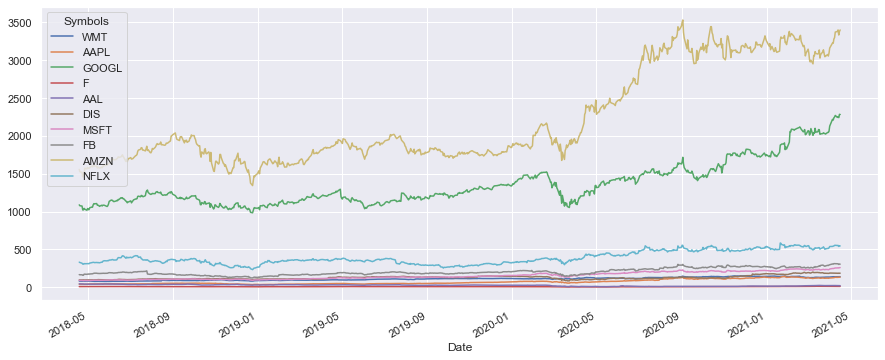

In [7]:
df.plot(figsize=fsize);


Now we want to start making interesting questions like: How much do these stocks return on a daily basis?
We could plot this over time but it is much more interesting to look at a KDE density plot to see how much these stocks return on average. 

Daily returns $r_n$ are defined as 

$$r_n = \frac{StockPrice_{n} - StockPrice_{n-1}}{ StockPrice_{n-1} }$$

where $StockPrice_{n}$ is the price of a given stock at time $n$.

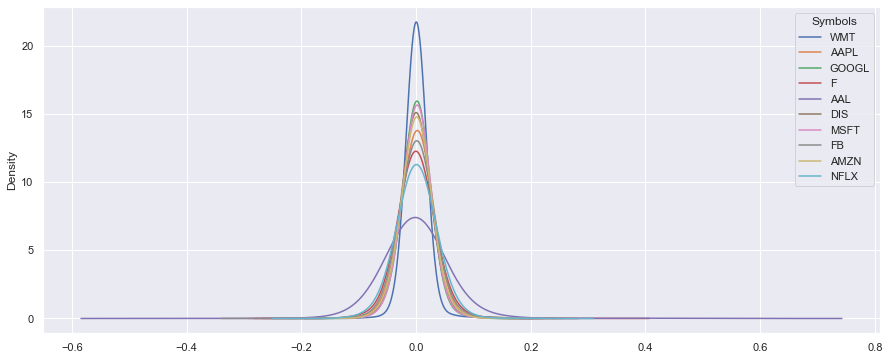

In [8]:
# plt.figure(figsize=(15,5))
daily_returns = df/df.shift(1)-1
daily_returns.plot.kde(figsize=(15,6) , bw_method=1); #We need to specify bw_method to have something closer to what we would get if we calculated the mean, variance and plotted these normal distributions

<AxesSubplot:xlabel='Date'>

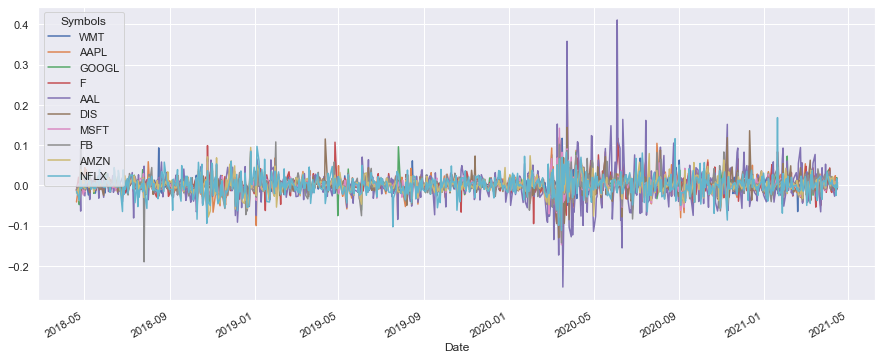

In [11]:
daily_returns.plot(figsize=(15,6))

We can see that these plots tell us the distribution of returns is close to being normal; in agreement with [modern portfolio](https://www.investopedia.com/terms/m/modernportfoliotheory.asp#:~:text=Modern%20portfolio%20theory%20(MPT)%20is,Journal%20of%20Finance%20in%201952.) theory by Markowitz 

In [44]:
daily_returns.mean().sort_values(ascending=False)

Symbols
AMZN     0.001565
NFLX     0.001506
MSFT     0.001403
AAPL     0.001170
FB       0.000931
GOOGL    0.000805
WMT      0.000671
DIS      0.000155
F       -0.000189
AAL     -0.000436
dtype: float64

In [45]:
daily_returns.var().sort_values(ascending=False)

Symbols
AAL      0.001177
NFLX     0.000685
F        0.000435
FB       0.000405
AMZN     0.000360
AAPL     0.000334
MSFT     0.000304
DIS      0.000281
GOOGL    0.000274
WMT      0.000204
dtype: float64

## Skewness and kurtosis

**[Skewness](https://en.wikipedia.org/wiki/Skewness)** tells us about small deformations with respect to a normal distribution. A stock with positive skewness is a sign of having overall more returns.

**[Kurtosis](https://en.wikipedia.org/wiki/Kurtosis)** the excess of kurtosis quantifies how high are the tails of the distribution. The higher the kurtosis the higher the probability of outliers. This is a signal of high risk!
**NB:** the normal distribution has a kurtosis of 3 so if we have an *excess* kurtosis of say 1.1, we have to add 3 to it to get the raw kurtosis of 4.3



In [38]:
daily_returns.skew()

Symbols
AAL      1.953041
AAPL    -0.145837
AMZN     0.307100
DIS      0.142930
F        0.900557
FB      -0.485806
GOOGL   -0.163167
MSFT     0.142282
NFLX     0.158181
WMT      0.772558
dtype: float64

In [41]:
daily_returns.kurtosis()

Symbols
AAL      30.530426
AAPL      7.455568
AMZN      5.178318
DIS      14.814597
F        17.592093
FB       13.549776
GOOGL     6.741304
MSFT     11.564192
NFLX      4.911093
WMT      17.093560
dtype: float64

## Boxplot
Now let's take a look at a boxplot. This will tell us better the behaviour of the stocks in the analysed timeframe

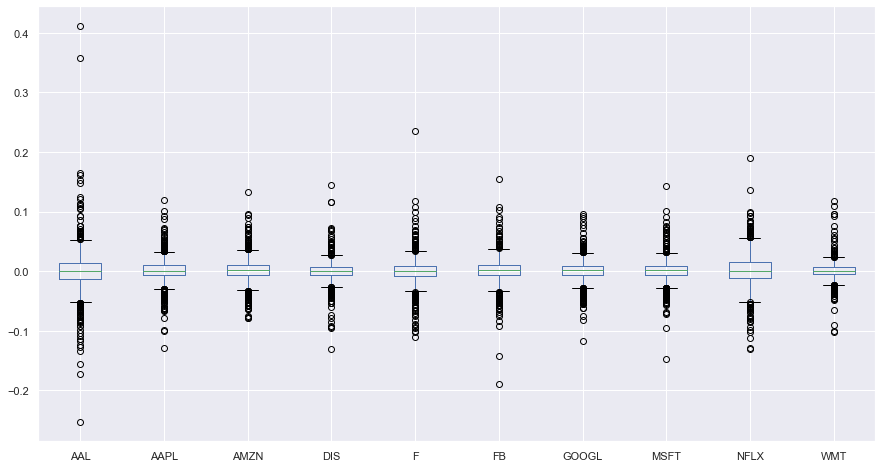

In [46]:
daily_returns.boxplot(figsize=(15,8));

## Violin plot
Since there are several outliers we cannot really tell if the plots are skewed towards one side or the other.
A violin plot might be better to see this:

(-0.1, 0.1)

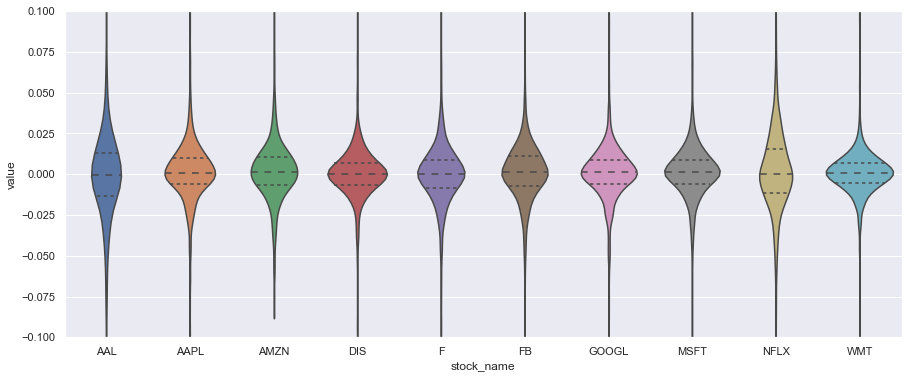

In [36]:
plt.figure(figsize=fsize)
df1 = pd.melt(daily_returns, var_name='stock_name' )
sns.violinplot(x='stock_name', y='value', data=df1, inner='quartile')
# plt.xticks(np.arange(np.round(np.min(df.values)),np.max(df.values),1.0 ) );
plt.ylim(-.1,.1)

This plot let's us visualize better the variance, mean and skewness. 

# Modern Portfolio Theory
In  1952 Harry Markowitz wrote an essay in which he introduced the idea of [Modern Portfolio Theroy](https://en.wikipedia.org/wiki/Modern_portfolio_theory) which later awarded him a Nobel Prize in Economics.

The basic underlying idea is that we can diversify an investment in different stocks (or products) to maximise the expected return for a given level of risk (or minimise the level of risk for a given expected return). In this theory we make use of variance as a proxy for risk.


In [8]:
def initialise_weights():
    'This functions returns a list of random weights for a given list of stocks'
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    return weights

# We use as default n_days 252 because that how many days the stock market is open every year
def portfolio_return(returns, weights, n_days=252):
    '''This function gives the expected return of a given portfolio for some weights.'''
    return np.sum(returns.mean()*weights)*n_days

def portfolio_var(returns,weights, n_days=252):
    ''''This function gives the variance of returns of a given portfolio for some weights.'''
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov()*n_days, weights ) )  )


In [9]:
w = initialise_weights()
preturn = portfolio_return(daily_returns, w)
pvar = portfolio_var(daily_returns, w)
print ('Portfolio Expected Returns: {}\nPortfolio Variance: {}'.format(preturn, pvar))

Portfolio Expected Returns: 0.22463227750754516
Portfolio Variance: 0.2448128946843565


## Monte Carlo generator
We now use a Monte-Carlo simulation, where we randomly pick all the weights (provided that they all add to 1) to see which portfolios would be the best.

We will make a color gradient to show the values of the [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) of the stocks given, which a measure of the performance of an investment compared to a risk-free asset.

In [10]:
def generate_portfolios(returns, n_days=252, n_portfolios=10):
    '''This function takes an array of returns, creates random portfolios and returns
    the expected return and variance of the portfolio. 
    returns (list): a list or an np array
    n_days (int): number of days to expect the return
    n_portfolios (int): number of portfolios to be created
    '''
    n_days = int(n_days)
    n_portfolios = int(n_portfolios)
    
    port_ret_list=[]
    port_var_list=[]
    for _ in range(n_portfolios):
        w = initialise_weights()
        port_ret_list.append(portfolio_return(returns, w, n_days) )
        port_var_list.append(portfolio_var(returns, w, n_days) )
    
    return np.array(port_ret_list), np.array(port_var_list)

# pf = generate_portfolios(daily_returns, 1, 20)
def plot_portfolios(returns, variances): 
    plt.figure(figsize=fsize)
    plt.scatter(variances, returns, c=returns/(variances), cmap='RdYlGn' )
    plt.xlabel('Expected Volatility (variance)')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.ylim(.95*returns.min(), 1.05*returns.max())
    plt.show()

# gen_returns, gen_variances =  generate_portfolios(daily_returns, n_days=252, n_portfolios=20000)
# plot_portfolios(gen_returns, gen_variances)

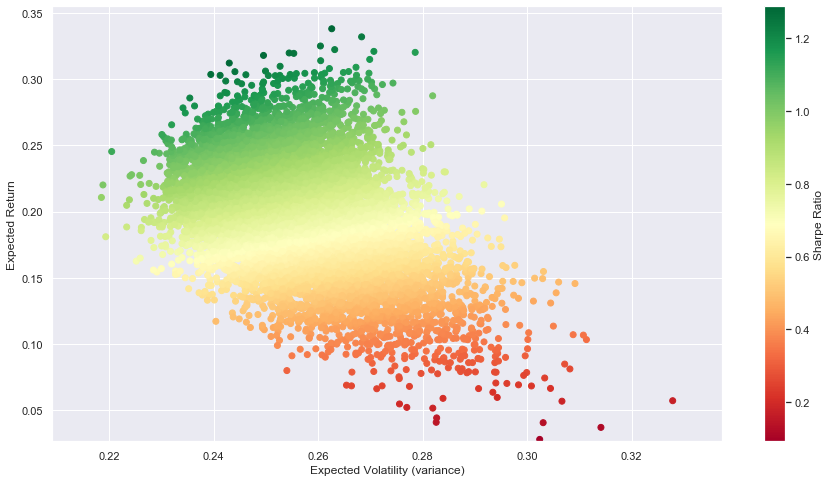

Wall time: 54.9 s


In [15]:
%%time
gen_returns, gen_variances =  generate_portfolios(daily_returns, n_days=252, n_portfolios=10000)
plot_portfolios(gen_returns, gen_variances)

## Optimisation of MPT
We can now try to find the portfolio that maximises the Sharpe ratio.

In [16]:
def sharpe(weights, returns, n_days=252): 
    pr = portfolio_return(returns, weights, n_days=n_days)
    pv = portfolio_var(returns, weights, n_days=n_days)
    #The minus sign below is needed because we want the Max of the Sharpe function 
    return -1* pr/pv
    
def best_portfolio(returns):
    #The method we use here will be Sequential Least SQuares Programming (SLSQP)
    bounds = tuple((0,1) for x in range(len(stocks))) # Weights can be only between 0 and 1
    constraints = ({'type':'eq', 'fun':lambda x:np.sum(x)-1 }) # The type of contraint is an equation that equals 0.
    optimum_weights = optim.minimize(fun=sharpe, x0=initialise_weights(), args=returns, 
                             method='SLSQP', constraints=constraints, bounds=bounds)
    pr = portfolio_return(returns, optimum_weights.x, n_days=252)
    pv = portfolio_var(returns, optimum_weights.x, n_days=252)
    print('''The optimal portfolio for the given individual returns 
    has an expected return of:   {}
    and an expected variance of: {}
    and a Shapre ratio of:       {}
    
    given by the weights {} '''.format(pr,pv,pr/pv,np.round(optimum_weights.x, decimals=4) ) )
    
    return optimum_weights.x



The optimal portfolio for the given individual returns 
    has an expected return of:   0.364239136820469
    and an expected variance of: 0.2498336481008977
    and a Shapre ratio of:       1.4579266627582828
    
    given by the weights [0.     0.1249 0.3892 0.     0.     0.     0.     0.2237 0.0283 0.234 ] 


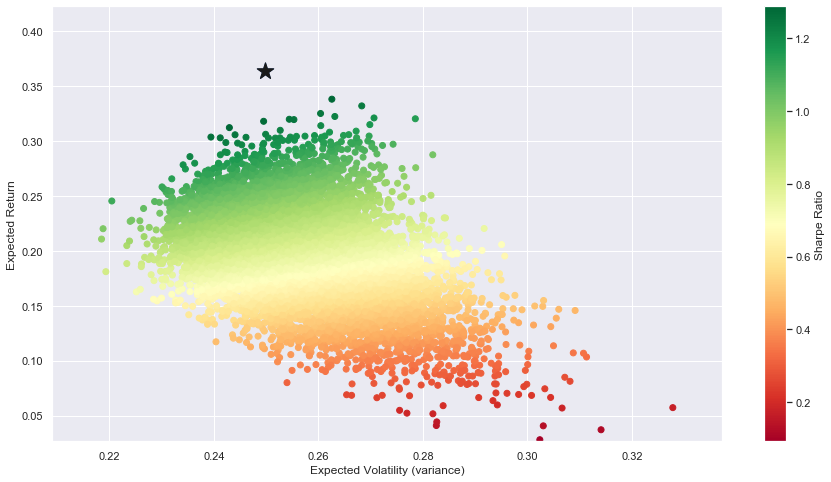

In [17]:
best = best_portfolio(daily_returns)
pr = portfolio_return(daily_returns, best, n_days=252)
pv = portfolio_var(daily_returns, best, n_days=252)
# print('\n{}\n{}\n\n'.format(pr,pv))

plt.figure(figsize=fsize)
# Plot all the random portfolios generated before.
plt.scatter(gen_variances, gen_returns, c=gen_returns/(gen_variances), cmap='RdYlGn' )
plt.xlabel('Expected Volatility (variance)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
#This will be the best portfolio! 😎

plt.ylim(.95*gen_returns.min(), 1.25*gen_returns.max())
plt.scatter(pv,pr, marker='*', s=300)
plt.scatter(pv,pr, marker='*',c='k', s=300)
plt.show()


**NB:** The more stocks there are to choose from, the more difficult it will be for Monte-Carlo methods to get close to the best portfolio. That's why the star seems to be somewhat distant from the other portfolios.

# Capital Asset Pricing Model
The CAPM is given by the following equation:

$$ E(r_a) = r_f + \beta_a (E(r_m) - r_f ) $$

where $r$ denotes the return and the subindices $a,f,m$ stand for: a given portfolio, free from risk and market and $\beta_a$ is the ratio between the covariance of $r_a$ and $r_m$ and the variance of $r_m$: 

$$\beta_a \equiv \frac{\text{cov}(r_a,r_m)}{ \text{cov}(r_m,r_m) }$$

As we can see from this definition, $\beta_a$ tells us how volatile the given portfolio is with respect to the "whole market".  

The equation of CAPM tells us that the *expected* return of the given portfolio is given as the return free from risk plus a premium for taking a riks, which is the product of how the portfolio varies with respect to the whole market ($\beta_a$) and how much more the market is expected to return with respect to the risk free products.

In [3]:
# There are some caveats of this function: 
# 1. I used monthly frequency and thus multiplied the exp_ret by 12 but this is different for different frequencies.
# 2. This function is designed to show how CAPM works. To make a much faster one, we don't need to plot anything and we could skip the whole for loop

def capm(start_date, end_date, stocks_list, freq='M', risk_free_rate =.05, plot=True):
    """This function gives the estimated return according to the Capital Asset Pricing Model
    The data taken from yahoo is resampled according to the parameter freq and gives back the mean
    of this timespan.
    Returns a data frame with the expected returns (according to CAPM) ordered from higher to lower. 
    
    start_date (str): string with the format 'dd/mm/yyyy'
    end_date (str): string with the format 'dd/mm/yyyy'
    stocks_list (list of strings): this has to be a list of string with the names of the stocks
    freq (str): This can be '2D', 'M', '3M', etc... 
    risk_free_rate (float): A variable that tells what is the return of products free of risk
    plot (bool): Whether or not to plot the stock returns with respect to the market (GSPC) returns and their linear regressions
    """
    # We first get the data of the stocks from yahoo finance
    df_all = web.DataReader(stocks, data_source= 'yahoo', start=start_date, end = end_date)['Adj Close']
    df_market =  web.DataReader(['^GSPC'], data_source= 'yahoo', start=start_date, end = end_date)['Adj Close']
    df = pd.concat([df_all, df_market], axis=1)
    
    # One-step returns
    ret = df/df.shift(1)-1
    ret = ret.dropna()
        
    #Get the covariance matrix
    covm = ret.cov()
    # Calculate the sensitivity beta by dividing by the variance og ^GSPC
    betam = covm/covm.iloc[-1,-1]
    
    #If we want to plot, we start the loop
    if plot:
        plt.figure(figsize=(15,12))
        plt.title('CAPM')
#         df_exp_ret = {}
        for k in range(len(ret.columns[:-1])): # remove the last one because it would plot the market with itself...
            # Select the subplot to be filled 
            plt.subplot(math.ceil(len(ret.columns[:-1])/3) , 3, k+1 )

            # Scatter plot of stock returns with respect to the market's
            plt.scatter(ret.iloc[:,-1], ret.iloc[:,k], alpha=.3)
            # We create a linear regression of degree 1
            beta, alpha = np.polyfit(ret.iloc[:,-1], ret.iloc[:,k], deg=1) # beta is the coefficient of x**1 and alpha is the intercept
            plt.plot( ret.iloc[:,-1], beta*ret.iloc[:,-1] + alpha , c='r', label='CAPM Line')
            # We multiply by 12 in the next line because we are considering monthly returns.
            exp_ret = risk_free_rate + betam.iloc[k,-1]*(12 * ret.iloc[:,k].mean())-risk_free_rate
#             df_exp_ret.update( {str(ret.columns[k]) : exp_ret} )

            #Plot formatting
            plt.title('{} expected return is {:.6f}'.format(str(ret.columns[k]), exp_ret), fontsize=12)
            plt.ylabel('Stock return $r_a$')
            plt.text(.04,-.08 , #r'$r_a = beta * r_m + alpha $'+'\n'+
                     '$\\beta=$ {:.5f}'.format(beta)+'\n'+'$\\alpha=$ {:.5f}'.format(alpha), fontsize=10)
            plt.ylim(-.25,.25)

            plt.xlabel('Market Return $r_m$');
        plt.tight_layout()
        plt.show()
        
#     #Create DataFrame where the expected returns are ordered from higher to lower values
#     indices = ['ExpRet']
#     df_exp_ret = pd.DataFrame(df_exp_ret, index=indices).transpose().sort_values(by='ExpRet', ascending=False)
    df_exp_ret = pd.DataFrame( risk_free_rate + betam.iloc[:,-1]*(12 * ret.mean())-risk_free_rate, columns=['ExpRet']).sort_values(by='ExpRet', ascending=False)
    
    return df_exp_ret

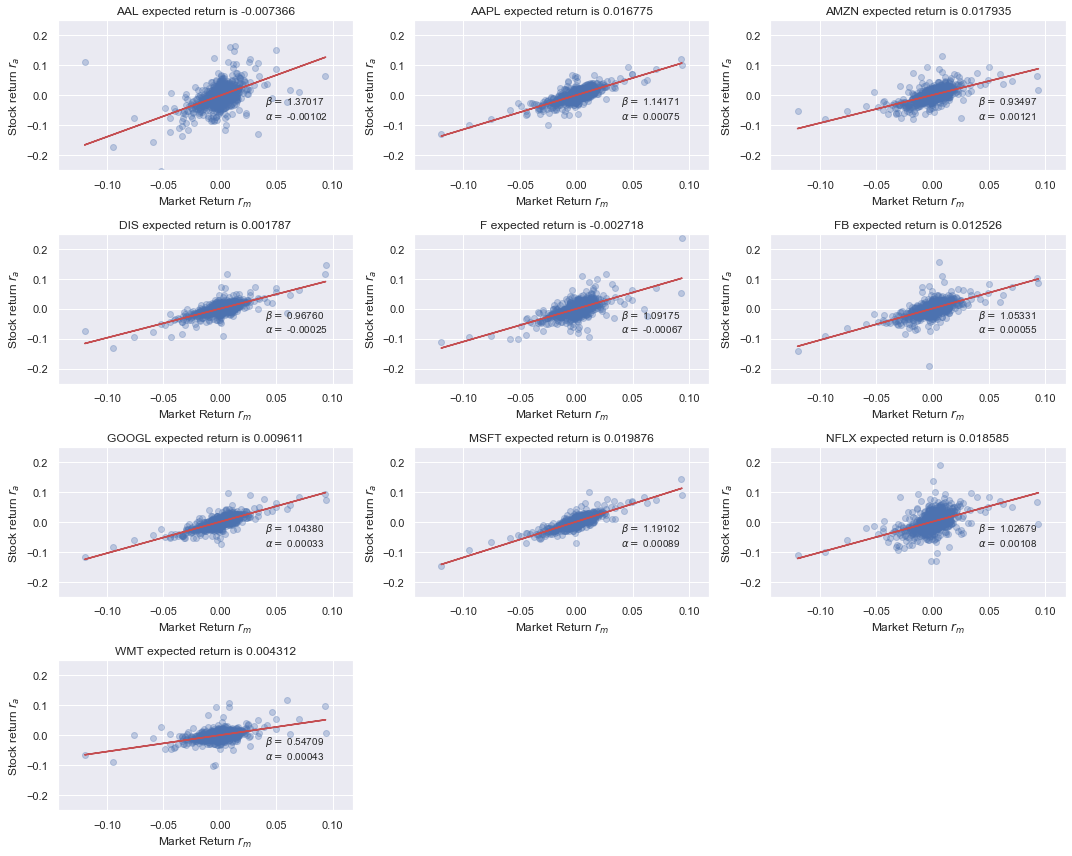

Wall time: 14.8 s


,ExpRet
Symbols,
MSFT,0.019876
NFLX,0.018585
AMZN,0.017935
AAPL,0.016775
FB,0.012526
GOOGL,0.009611
^GSPC,0.005031
WMT,0.004312
DIS,0.001787


In [4]:
%%time
exp_ret_capm = capm(start_date, end_date, stocks, plot=True)
exp_ret_capm

# Derivatives

A derivative is a security whose value is based on something else. This means its price is derived from one or more underlying assets. Its value is determined by fluctuations in the **underlying** asset.

**Hedging:** the use of derivatives to insure against risk in an asset

The most important types of derivatives are:

1. Futures: it is an agreement between to paries for the sale of an asset at an agreed upon price. Both seller and buyer are obliged to finish the transaction.
2. Options: it is very similar to a future with the main difference that one is not obliged to finish the transaction. One has the *right* to trade in the future at an agreed price. To know the price of an option we make use of the **Black-Scholes** model (we will later talk about this). The actual price of the stock at time $t$ is denoted by $S(t)$, the Exercise Price ($E$ and also called strike price) is the price we will have the right to buy at and the expiration date ($T$) is the time when we can buy the underlying asset. There are 2 types of options:
    * Call option: right to buy at an agreed price (we speculate that the price will rise)
    * Put option: right to sell at an agreed price (we speculate the price will fall)

**NB:** American options may be exercised at any time $t<T$ whereas European options can only be exercised at time $T$.



## Stochastic calculus

The return of stock $S$ may be expressed by $S(t+dt)-S(t) = dS$ and this difference can be modelled as a stochastic process:

$$ dS = \mu(S,t)~ dt + \sigma(S,t) ~dX, $$

where $\mu$ is the mean or expected value of the returns, $dt$ a time step, $\sigma$ its standard deviation and $dX$ is the differential of a random variable (like a variable describing a [brownian particle](https://en.wikipedia.org/wiki/Brownian_motion#:~:text=Brownian%20motion%2C%20or%20pedesis%20(from,moving%20molecules%20in%20the%20fluid.)).
Since $X$ is simliar to the position of a particle in the study of a brownian motion, it is reasonable to say that the expected value of this variable is zero $E[dx]=0$ and that its variance is proportional to the time passed 
$$\sigma_{dX}^2 = E[dx^2] \propto dt$$

we can define a constant $\alpha$ such that 
$$E[dX^2] = \alpha dt.$$

Before studying some important calculus equations let's do a bit more on Brownian motion:

### Implementation of brownian motion
Here we will plot a 1 dimensional particle movement

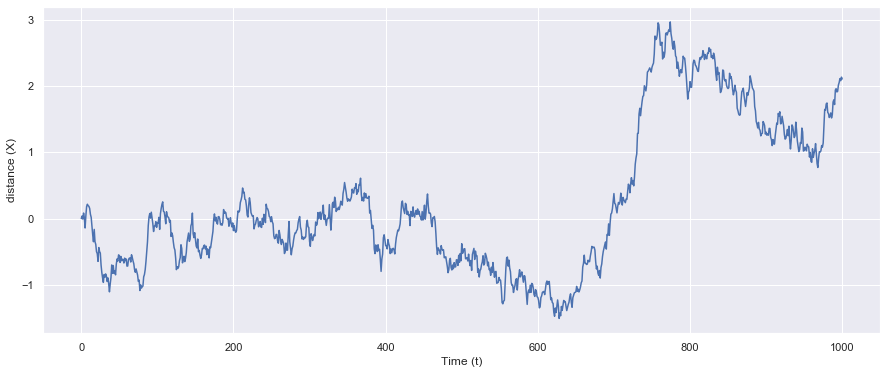

Wall time: 374 ms


In [83]:
%%time
def brownian(x0=0, dt=.1, N=100, plot=True):
    # Initialise the positions
    v = np.zeros(N+1)
    # Create timesteps (only useful to plot)
    t = np.arange(0,N+1,1)
    
    # Brownian motion is given by a normal distribution. Hence, we need to consider a variable with this distribution 
    v[1:] = np.cumsum(np.random.normal(0,dt,N) )
    
    if plot:
        plt.figure(figsize=fsize)
        plt.plot(t,v) 
        plt.xlabel('Time (t)')
        plt.ylabel('distance (X)');
        plt.show()

brownian(N=1000,dt=.1)

### Stochastic Taylor expansions
Since we are dealing with stochastic variables, we have to look more carefully into the derivatives of these variables.

We begin by noticing that small changes in a stochastic variable lead to small changes in functions $F$ depending on such stochastic variables. *I.e.* 
$$dF(X) = F(X+dX) - F(X)$$

Hence, making a Taylor expansion of this function around a value $a$, we get:

$$
\begin{align}
dF &= \left. \frac{dF}{dX}\right|_{x=a}dX + \frac{1}{2!} \left.\frac{d^2F}{dX^2}\right|_{x=a} dX^2 \\~\\
dF &= \left. \frac{dF}{dX}\right|_{x=a}dX + \frac{1}{2!} \left.\frac{d^2F}{dX^2}\right|_{x=a} (\alpha ~ dt),
\end{align}
$$

where here $\alpha$ is a proportionality constant related to the *diffusion* of the return of the stock (in this case).

**Jargon alert:** this last equation with the taylor expansion written in terms of both $dX$ and $dt$ is known in finance as **Ito's lemma**.

## Ito's lemma for derivatives
We now want to make use of this insight for derivatives' pricing.
Supposing we have a stock which is a function of time,
$$dS(t) = \mu(S,t)~ dt + \sigma(S,t) ~dX$$

We know that a derivative's pricing $V(S,t)$ depends on the price of an underlying asset (say a stock) $S$ and time $t$. Hence:

$$\begin{align}
V(S+d S, t+dt) &= V(S,t) +  \frac{\partial V}{\partial S} dS + \frac{\partial V}{\partial t} dt + \frac{1}{2!}\left[ \frac{\partial^2 V}{\partial S^2} dS^2 + \frac{\partial^2 V}{\partial t^2} dt^2 +  \frac{\partial^2 V}{\partial S \partial t} dS~dt
\right] + \ldots\\
\therefore ~~~~~~~~~~~ dV &=  \frac{\partial V}{\partial S} dS + \frac{\partial V}{\partial t} dt + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} dS^2 + \ldots
\end{align}
$$

Since we know that $dX^2\propto dt,$ we know that the change in $dt$ is smaller (closer to 0) than $dX$ and hence, we *can* consider it negligible.

Now, substituting 
$$dS^2 \approx \sigma^2 dX^2+\ldots$$ 
in the last equation, we obtain
$$\begin{align}
dV &=  \frac{\partial V}{\partial S} dS + \frac{\partial V}{\partial t} dt + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 dX^2 + \ldots\\
&=  \frac{\partial V}{\partial S} dS + \frac{\partial V}{\partial t} dt + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 dt+\ldots
\end{align}
$$

which can also be written as
$$
dV =  \left(\mu \frac{\partial V}{\partial S} + \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 \right)dt+ \sigma dX + \ldots
$$

## [Black Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) (1973)

The aim now is to calculate the price of a derivative associated with an underlying European option for a time $t$ less than the expiry time $T$ ($t<T$).
The greatness of this model comes from the fact that by combining risky assets one can eliminate risk itself. 

As we can remember there are two ways to get rid of the unsystematic risk (this means risk specific to individual stocks):
* In Modern Portfolio Theory, one includes several stocks in a portfolio to reduce unsystematic risk.
* In CAPM we can eliminate unsystematic risk but the market risk cannot be diversified away.

However, to get rid of the systematic risk (market risk) we need something more than diversifying, we need another strategy: Delta-hedging and pairs-trading can eliminate all risk!!

We begin by reminding ourselves that the price of an option $V$ is a function of several factors:

$$V = V(S,t,\sigma, \mu, E,T,r_f),$$

* $S$ is the price of the underlying stock 
* $t$ the time at which we wil calclate it's price
* $\sigma$ and $\mu$ are the volatility and mean of the stock associated with the option
* $E$ is the strike price (price agreed upon) of the stock
* $T$ the expiry time 
* $r_f$ is a parameter associated with a risk-free rate.

Also, remember that a **call option** (right to *buy* at an price $E$ at time $T$) is positively correlated with the stock price and a **pt option** (right to *sell* at an price $E$ at time $T$) is negatively correlated with it.

Therefore, we can exploit these two correlations and end up with a special portfolio:

$$\pi = \underbrace{V(S,t)}_{\text{long position}} - \underbrace{\Delta S}_{\text{short position}} $$

Basically we long (buy) the option and short (sell) a portion of the underlying stock.

The Black Scholes model **assumes** that the underlying asset follows a random walk
$$dS = \mu_S dt + \sigma_S dX$$

The portfolio $\pi$ changes from time $t$ to $t+dt$ because of the change in the option $V(S,t)$ and because of the change in the underlying asset $S(t)$ as well. So, following Itto's lemma, the change of the price in our portfolio $\pi$ is given by
$$\begin{align}
d\pi &= dV(S,t) - \Delta dS \\
&=  \left(\mu \frac{\partial V}{\partial S} + \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 \right)dt+ \sigma dX  - {\Delta dS} + \ldots \\
&= \left( \mu \frac{\partial V}{\partial S} + \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 - \Delta \mu \right)dt+ ( 1 - \Delta )\sigma~ dX + \ldots
\end{align}
$$

or in terms of $S$ and $t$, we get
$$\begin{align}
d\pi
&= \underbrace{\left( \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 \right)dt}_{\text{Deterministic}}+ \underbrace{\left(  \frac{\partial V}{\partial S} - \Delta \right) dX}_{\text{Stochastic}} + \ldots
\end{align}
$$

As we can see, one can get rid of the stochastic part if 

$$ \frac{\partial V}{\partial S} - \Delta = 0.$$

**Hedging** is the elimination of randomness.

This means that 
$$
d\pi = \left( \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 \right)dt
$$
this is free of risk but we know that this should then be related to the risk-free rate $r_f$.
The no-arbitrage principle says that the risk-free change $d\pi$ is the same as the growth one would get if we lend the same amount of cash to a bank

$$d\pi = r_f \pi dt$$

This in turn tells us that (since $\pi = V -\Delta S$)
$$
 \left( \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2 \right)dt = r_f \left(V - \frac{\partial V}{\partial S} \right)dt
$$
and hence,

$$  \frac{\partial V}{\partial t} + \frac{\alpha}{2} \frac{\partial^2 V}{\partial S^2} \sigma^2  - r_f V + r_f \frac{\partial V}{\partial S} = 0
$$

This is the **Black Scholes** equation and is a parabolic partial differential equation.

# working zone

In [8]:
df1 = web.DataReader(['^GSPC'], data_source= 'yahoo', start=start_date, end = end_date)['Adj Close']

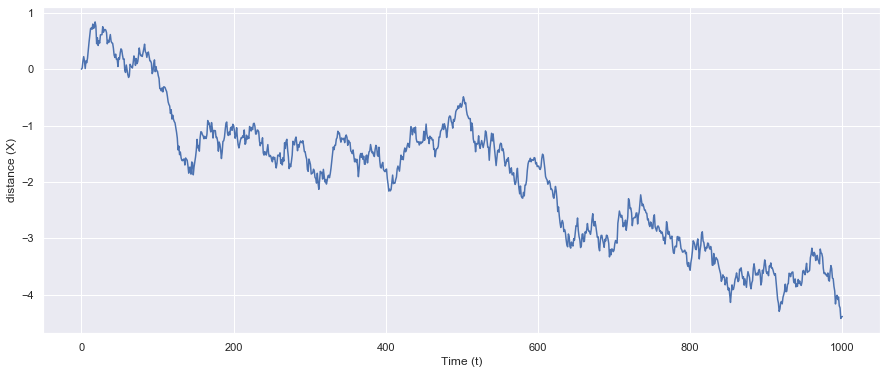

Wall time: 330 ms
